# 1. 준비

## 1-1. 데이터 불러오기, 패키지 설치

In [196]:
!sudo apt-get install -y fonts-nanum    # 나눔 폰트 설치
!sudo fc-cache -fv                      # 시스템의 글꼴 정보 캐시를 업데이트
!rm ~/.cache/matplotlib -rf             # matplotlib 글꼴 캐시를 remove

# 이후 런타임 초기화

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [197]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
import re
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

font_path = "/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf"

In [199]:
df = pd.read_excel('/content/drive/MyDrive/ESAA/24-1 방학/전처리후.xlsx')
df = df.drop('Unnamed: 0',axis=1)

In [200]:
img_cluster = pd.read_excel('/content/drive/MyDrive/ESAA/24-1 방학/img_cluster8.xlsx')
img_cluster = img_cluster['cluster8']

In [201]:
img_cluster

0       7
1       7
2       3
3       2
4       7
       ..
2248    1
2249    2
2250    5
2251    1
2252    7
Name: cluster8, Length: 2253, dtype: int64

In [202]:
df = pd.concat([df,img_cluster],axis=1)
df.head(2)

,Title,Genre,Story,Keywords,Likes,Age,Link,Day,Rank,plat,Story_clean,Story_clean1,Story_clean2,cluster8
0,관계 지향적 관계,로맨스,첫사랑과 1주년이 된 한결은 섹스가 불가능하다는 이유로 차이게 도니다. 실연의 아픔...,"따뜻한,설레는,로맨스,로맨스코미디물",229000,19,https://webtoon.kakao.com/content/%EA%B4%80%EA...,mon,1,kakao,첫사랑과 1주년이 된 한결은 섹스가 불가능하다는 이유로 차이게 도니다 실연의 아픔을...,"['첫사랑', '주년', '한결', '섹스', '이유', '차이', '도니', '실...","['첫사랑', '1', '주년', '한결', '섹스', '불가능하다', '이유', ...",7
1,이번 생은 가주가 되겠습니다,로맨스 판타지,"“…한번 해 보자. 내가 가주가 되는 거야.” 제국에서 제일가는 가문, 롬바르디...","통쾌한,몰입되는,로맨스 판타지,회귀물",1730000,전체,https://webtoon.kakao.com/content/%EC%9D%B4%EB...,mon,2,kakao,한번 해 보자 내가 가주가 되는 거야 제국에서 제일가는 가문 롬바르디의 사생아로 환...,"['한번', '가주', '제국', '일가', '가문', '롬바르디', '사생아', ...","['한번', '보다', '가주', '거야', '제국', '제', '일가', '가문'...",7


In [203]:
df.shape

(2253, 14)

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253 entries, 0 to 2252
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         2253 non-null   object
 1   Genre         2253 non-null   object
 2   Story         2253 non-null   object
 3   Keywords      2253 non-null   object
 4   Likes         2253 non-null   int64 
 5   Age           2253 non-null   object
 6   Link          2253 non-null   object
 7   Day           2253 non-null   object
 8   Rank          2253 non-null   int64 
 9   plat          2253 non-null   object
 10  Story_clean   2253 non-null   object
 11  Story_clean1  2253 non-null   object
 12  Story_clean2  2253 non-null   object
 13  cluster8      2253 non-null   int64 
dtypes: int64(3), object(11)
memory usage: 246.5+ KB


## 1-2 변수 전처리

### (1) Likes

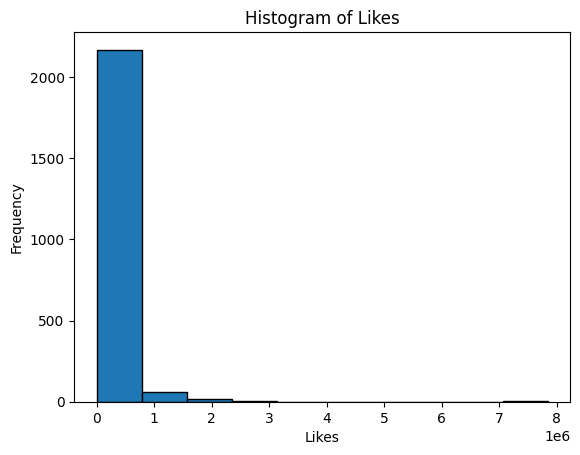

In [205]:
plt.hist(df['Likes'], bins=10, edgecolor='black')
plt.xlabel('Likes')
plt.ylabel('Frequency')
plt.title('Histogram of Likes')
plt.show()

- right skewed
- 이상치가 존재함

In [206]:
df['Likes_log'] = np.log1p(df['Likes'])

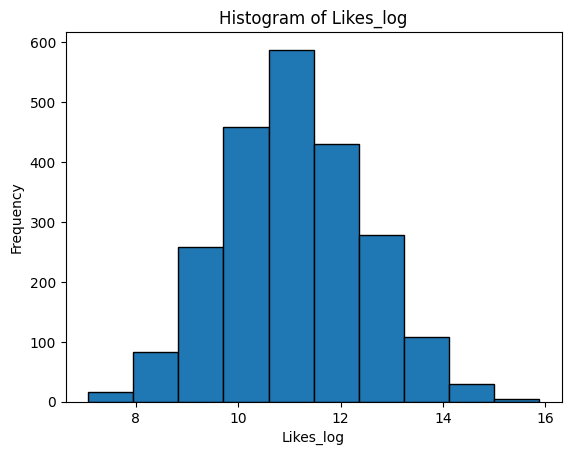

In [207]:
plt.hist(df['Likes_log'], bins=10, edgecolor='black')
plt.xlabel('Likes_log')
plt.ylabel('Frequency')
plt.title('Histogram of Likes_log')
plt.show()

In [208]:
# 플랫폼별로 Likes 변수 정규화
scaler = MinMaxScaler()
df['Likes_normalized'] = df.groupby('plat')['Likes_log'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).ravel())
df.head(2)

,Title,Genre,Story,Keywords,Likes,Age,Link,Day,Rank,plat,Story_clean,Story_clean1,Story_clean2,cluster8,Likes_log,Likes_normalized
0,관계 지향적 관계,로맨스,첫사랑과 1주년이 된 한결은 섹스가 불가능하다는 이유로 차이게 도니다. 실연의 아픔...,"따뜻한,설레는,로맨스,로맨스코미디물",229000,19,https://webtoon.kakao.com/content/%EA%B4%80%EA...,mon,1,kakao,첫사랑과 1주년이 된 한결은 섹스가 불가능하다는 이유로 차이게 도니다 실연의 아픔을...,"['첫사랑', '주년', '한결', '섹스', '이유', '차이', '도니', '실...","['첫사랑', '1', '주년', '한결', '섹스', '불가능하다', '이유', ...",7,12.341482,0.598637
1,이번 생은 가주가 되겠습니다,로맨스 판타지,"“…한번 해 보자. 내가 가주가 되는 거야.” 제국에서 제일가는 가문, 롬바르디...","통쾌한,몰입되는,로맨스 판타지,회귀물",1730000,전체,https://webtoon.kakao.com/content/%EC%9D%B4%EB...,mon,2,kakao,한번 해 보자 내가 가주가 되는 거야 제국에서 제일가는 가문 롬바르디의 사생아로 환...,"['한번', '가주', '제국', '일가', '가문', '롬바르디', '사생아', ...","['한번', '보다', '가주', '거야', '제국', '제', '일가', '가문'...",7,14.363633,0.828269


In [209]:
df1 = df.copy()

### (2) 장르

In [210]:
df['Genre'].value_counts()

Genre
로맨스 판타지    573
로맨스        443
드라마        205
판타지 드라마    194
판타지        187
액션/무협      162
학원/판타지     125
액션          88
스릴러         77
일상          46
개그          42
무협/사극       39
공포/스릴러      27
코믹/일상       22
스포츠         15
감성           8
Name: count, dtype: int64

In [211]:
df.groupby(['plat', 'Genre']).size()

plat   Genre  
kakao  공포/스릴러      27
       드라마         87
       로맨스        194
       로맨스 판타지    573
       액션/무협      162
       코믹/일상       22
       판타지 드라마    194
       학원/판타지     125
naver  감성           8
       개그          42
       드라마        118
       로맨스        249
       무협/사극       39
       스릴러         77
       스포츠         15
       액션          88
       일상          46
       판타지        187
dtype: int64

- 코믹/일상

In [212]:
df1['Genre'] = df1['Genre'].replace({'개그': '코믹/일상', '일상': '코믹/일상'})

- 스릴러

In [213]:
df1['Genre'] = df1['Genre'].str.replace("공포/스릴러", '스릴러')

- 감성

In [214]:
df1[df1['Genre'] == '감성']

,Title,Genre,Story,Keywords,Likes,Age,Link,Day,Rank,plat,Story_clean,Story_clean1,Story_clean2,cluster8,Likes_log,Likes_normalized
1443,밥 먹고 갈래요?,감성,이리 뛰고 저리 뛰고 깨지고 구르고. 지칠대로 지친 주중을 보내고 나면 찾아오는 ...,"감성,음식&요리,완결무료,완결감성",398410,전체,https://comic.naver.com/webtoon/list?titleId=6...,complete,60,naver,이리 뛰고 저리 뛰고 깨지고 구르고 지칠대로 지친 주중을 보내고 나면 찾아오는 주말...,"['저리', '주중', '주말', '힐링', '타임', '오묘', '작가', '컷툰...","['이리', '뛰다', '저리', '뛰다', '깨지다', '구르다', '지치다', ...",5,12.895239,0.746089
1520,웅크,감성,그시절 우리가 사랑했던 웹툰 <일상날개짓> 나유진 작가님의 힐링 차기작. '나는 왜...,"감성,유료화임박,무해한,힐링,완결무료,완결감성",66179,전체,https://comic.naver.com/webtoon/list?titleId=8...,complete,137,naver,그시절 우리가 사랑했던 웹툰 일상날개짓 나유진 작가님의 힐링 차기작 나는 왜 태어났...,"['시절', '우리', '사랑', '웹툰', '일상날개짓', '나유진', '작가',...","['시절', '우리', '사랑', '웹툰', '일상날개짓', '나유진', '작가',...",6,11.100134,0.502204
1612,불편한 편의점,감성,불편한데 자꾸 가고 싶은 편의점이 있다! 어느날 작은 편의점에 노숙자(?)조폭(?)...,"감성,무해한,힐링,성장드라마,감성드라마,소설원작",37892,전체,https://comic.naver.com/webtoon/list?titleId=8...,mon,29,naver,불편한데 자꾸 가고 싶은 편의점이 있다 어느날 작은 편의점에 노숙자 조폭 처럼 보이...,"['자꾸', '편의점', '날', '편의점', '노숙자', '조폭', '처럼', '...","['불편하다', '자꾸', '가다', '싶다', '편의점', '어느', '날', '...",3,10.542522,0.426447
1672,프로페서,감성,“자네라면 내 유고를 맡길 수 있겠어. 이어서 써 줄 텐가?” 세계적인 학자의 유품...,"감성,성장물,성장드라마,감성드라마,소설원작",4946,12,https://comic.naver.com/webtoon/list?titleId=8...,mon,89,naver,자네라면 내 유고를 맡길 수 있겠어 이어서 써 줄 텐가 세계적인 학자의 유품을 물려...,"['유고', '수', '줄', '텐', '세계', '학자', '유품', '대학원생'...","['자다', '유고', '맡기다', '수', '이어서', '써다', '줄', '텐'...",5,8.506537,0.149836
1722,연우의 순정,감성,여학생으로 오해받을 정도로 여리여리한 외모를 가진 연우. 그는 교내 인기스타인 강...,"감성,다정남,걸크러시",255358,15,https://comic.naver.com/webtoon/list?titleId=7...,tue,45,naver,여학생으로 오해받을 정도로 여리여리한 외모를 가진 연우 그는 교내 인기스타인 강해솔...,"['여학생', '오해', '정도', '외모', '연우', '교내', '인기', '스...","['여학생', '오해', '받다', '정도', '여리다', '여리다', '외모', ...",0,12.450426,0.685656
1910,추억이 찾아오는 가게,감성,"""이 돈, 다 언니 가져."" 내 인생에 이런 날도 있다니. 잠깐, 소미 넌 인형 ...",감성,23485,전체,https://comic.naver.com/webtoon/list?titleId=8...,thu,45,naver,이 돈 다 언니 가져 내 인생에 이런 날도 있다니 잠깐 소미 넌 인형 아니었어 아무...,"['돈', '언니', '인생', '날', '잠깐', '소', '넌', '인형', '...","['돈', '언니', '가다', '인생', '이렇다', '날', '잠깐', '소',...",0,10.064160,0.361456
2037,우리는 후라이족,감성,심한 천식질환으로 시골로 이사오게 된 11살 소년 호준이. 어느 날 밤. 푸른 눈을...,"감성,무해한,러블리,힐링,인외존재",20081,전체,https://comic.naver.com/webtoon/list?titleId=8...,fri,79,naver,심한 천식질환으로 시골로 이사오게 된 11살 소년 호준이 어느 날 밤 푸른 눈을 가...,"['천식', '질환', '시골', '이사오', '살', '소년', '호준이', '날...","['심하다', '천식', '질환', '시골', '이사오', '11', '살', '소...",4,9.907579,0.340183
2172,이발소 밑 게임가게,감성,"열정적으로 좋아하는 것도, 딱히 이루고 싶은것도 없는 고등학교 1학년인 미소. 하루...",감성,69985,전체,https://comic.naver.com/webtoon/list?titleId=8...,sun,21,naver,열정적으로 좋아하는 것도 딱히 이루고 싶은것도 없는 고등학교 1학년인 미소 하루하루...,"['열정', '고등학교', '학년', '미소', '하루하루', '무난', '하교',...","['열정', '적', '좋아하다', '딱하다', '이루다', '싶다', '없다', ...",1,11.156051,0.509801


In [215]:
df1[df1['Genre'] == '드라마']

,Title,Genre,Story,Keywords,Likes,Age,Link,Day,Rank,plat,Story_clean,Story_clean1,Story_clean2,cluster8,Likes_log,Likes_normalized
2,더 그레이트,드라마,"언젠가는 꿈꾸는 소녀, 언젠가는 사랑을 하는 여자. 지금은 두 아이의 가장, 엄마...","감동적인,가슴 먹먹한,드라마,힐링물",377000,전체,https://webtoon.kakao.com/content/%EB%8D%94-%E...,mon,3,kakao,언젠가는 꿈꾸는 소녀 언젠가는 사랑을 하는 여자 지금은 두 아이의 가장 엄마로 살고...,"['소녀', '사랑', '여자', '지금', '두', '아이', '가장', '엄마'...","['언젠가', '늘다', '꿈꾸다', '소녀', '언젠가', '늘다', '사랑', ...",3,12.840003,0.655248
19,도령의 가족,드라마,"장녀, 장남, 차녀, 차남, 삼녀... 그리고 귀여운 막냉이까지! 짜맞춘 듯 아들 ...","발랄한,공감되는,드라마,힐링물",75000,전체,https://webtoon.kakao.com/content/%EB%8F%84%EB...,mon,20,kakao,장녀 장남 차녀 차남 삼녀 그리고 귀여운 막냉이까지 짜맞춘 듯 아들 딸 세 명씩 모...,"['장녀', '장남', '차녀', '차남', '녀', '막', '냉이', '듯', ...","['장녀', '장남', '차녀', '차남', '삼', '녀', '그리고', '귀엽다...",5,11.225257,0.471880
29,메지나,드라마,"""왕자님이 제게 느낀 것은 사랑이 아닙니다. 사랑이 아닐 뿐더러, 사랑이어서도 안...","처절한,긴장감 있는,드라마,암투물",53000,전체,https://webtoon.kakao.com/content/%EB%A9%94%EC...,mon,30,kakao,왕자님이 제게 느낀 것은 사랑이 아닙니다 사랑이 아닐 뿐더러 사랑이어서도 안 됩니다...,"['왕자', '제', '사랑', '사랑', '뿐더러', '사랑', '안', '파괴'...","['왕자', '님', '제', '느끼다', '사랑', '아니다', '사랑', '아니...",4,10.878066,0.432453
45,롱리브더킹,드라마,한 여인을 위해 불가능에 도전하는 남자가 있다. 의리와 사랑을 빼고는 아무것도 없다...,"감동적인,분노유발,드라마,정치물",294000,전체,https://webtoon.kakao.com/content/%EB%A1%B1%EB...,mon,46,kakao,한 여인을 위해 불가능에 도전하는 남자가 있다 의리와 사랑을 빼고는 아무것도 없다고...,"['여인', '위해', '불가능', '도전', '남자', '의리', '사랑', '말...","['여인', '위해', '불가능', '도전', '남자', '의리', '사랑', '빼...",6,12.591338,0.627010
71,다시 한번 아이돌,드라마,데뷔를 눈앞에 둔 아이돌 그룹의 멤버 ‘서현우’. 프로필 촬영 날 현장 당시의 사고...,"설레는,귀여운,드라마,회귀물",121000,전체,https://webtoon.kakao.com/content/%EB%8B%A4%EC...,mon,72,kakao,데뷔를 눈앞에 둔 아이돌 그룹의 멤버 서현우 프로필 촬영 날 현장 당시의 사고로 인...,"['데뷔', '눈앞', '아이돌', '그룹', '멤버', '서현우', '프로필', ...","['데뷔', '눈앞', '두다', '아이돌', '그룹', '멤버', '서현우', '...",1,11.703554,0.526194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,갑!자기 건물주,드라마,갑자기 건물주가 되어버린 대학생 김가비. 그녀의 운명을 바꾸고 사라졌던 남자 이지을...,드라마,48473,12,https://comic.naver.com/webtoon/list?titleId=8...,sun,48,naver,갑자기 건물주가 되어버린 대학생 김가비 그녀의 운명을 바꾸고 사라졌던 남자 이지을 ...,"['갑자기', '건물', '주가', '대학생', '김', '가비', '그녀', '운...","['갑자기', '건물', '주가', '되어다', '버리다', '대학생', '김', ...",3,10.788783,0.459904
2207,자매전쟁,드라마,"단 하나로 인정받고 싶었던 두 소녀, 예술고등학교 1등과 2등을 앞다투는 '원리온'...","드라마,계략여주,학원로맨스,복수극",343731,12,https://comic.naver.com/webtoon/list?titleId=7...,sun,56,naver,단 하나로 인정받고 싶었던 두 소녀 예술고등학교 1등과 2등을 앞다투는 원리온 과 ...,"['단', '하나로', '두', '소녀', '예술', '고등학교', '앞', '원리...","['단', '하나로', '인정받다', '싶다', '두', '소녀', '예술', '고...",0,12.747618,0.726033
2227,로봇소녀 노이도,드라마,말 더듬 때문에 사람과 대화할 수 없는 고등학교 1학년 노이도. 어느 날 처음으로 ...,"드라마,성장물,무해한,힐링,sf,학원로맨스",19189,전체,https://comic.naver.com/webtoon/list?titleId=8...,sun,76,naver,말 더듬 때문에 사람과 대화할 수 없는 고등학교 1학년 노이도 어느 날 처음으로 대...,"['말', '때문', '사람과', '대화', '수', '고등학교', '학년', '날...","['말', '더듬다', '때문', '사람과', '대화', '수', '없다', '고등...",3,9.862145,0.334010
2235,아빠는 버츄얼 아이돌,드라마,엄마가 돌아가신 이후 다정은 외로워하는 아빠가 걱정되어 다니던 회사를 정리하고 고향...,드라마,22041,12,https://comic.naver.com/webtoon/list?titleId=8...,sun,84,naver,엄마가 돌아가신 이후 다정은 외로워하는 아빠가 걱정되어 다니던 회사를 정리하고 고향...,"['엄마', '이후', '다정', '외로워', '아빠', '걱정', '회사', '정...","['엄마', '돌아가다', '이후', '다정', '외로워', '아빠', '걱정', ...",2,10.000705,0.352835


In [216]:
df1['Genre'] = df1['Genre'].str.replace("감성", '드라마')

- 판타지

-> 판타지, 판타지 드라마, 학원/판타지 모두 포함

In [217]:
df1['Genre'] = df1['Genre'].replace({'학원/판타지': '판타지', '판타지 드라마': '판타지'})

- 로맨스

-> 로맨스, 로맨스 판타지

In [218]:
df1['Genre'] = df1['Genre'].str.replace("로맨스 판타지", '로맨스')

- 액션/무협/사극

-> 스포츠 포함

In [219]:
df1['Genre'] = df1['Genre'].replace({'액션/무협': '액션/무협/사극', '무협/사극': '액션/무협/사극', '액션': '액션/무협/사극', '스포츠': '액션/무협/사극'})

- 완성

In [220]:
df1.groupby(['plat', 'Genre']).size()

plat   Genre   
kakao  드라마          87
       로맨스         767
       스릴러          27
       액션/무협/사극    162
       코믹/일상        22
       판타지         319
naver  드라마         126
       로맨스         249
       스릴러          77
       액션/무협/사극    142
       코믹/일상        88
       판타지         187
dtype: int64

In [221]:
df1['Genre'].value_counts()

Genre
로맨스         1016
판타지          506
액션/무협/사극     304
드라마          213
코믹/일상        110
스릴러          104
Name: count, dtype: int64

In [222]:
df2 = df1.copy()

In [223]:
df2['Original_Genre'] = df2['Genre']
df2 = pd.get_dummies(df2, columns=['Genre'], prefix='Genre')
df2['Genre'] = df2['Original_Genre']

### (3) plat

In [224]:
df2['Original_plat'] = df2['plat']
df2 = pd.get_dummies(df2, columns=['plat'], prefix='plat')
df2['plat'] = df2['Original_plat']

### (4) Age

In [225]:
# Age 통일
df2['Age'] = df2['Age'].astype(str)
df2['Age'] = df2['Age'].replace('성인', '19')
df2['Age'] = df2['Age'].replace('18', '19')
df2['Age'].value_counts()

Age
전체    1292
15     705
12     162
19      94
Name: count, dtype: int64

In [226]:
# 원핫 인코딩
df2 = pd.get_dummies(df2, columns=['Age'], prefix='Age')

In [227]:
df2=df2.drop(columns=["Age_12","Age_15","Age_전체"])

### (5) 완결

In [228]:
df2['Is_Complete'] = df2['Day'] == 'complete'

### (6) 완성된 데이터 프레임

In [229]:
df2.head(2)

,Title,Story,Keywords,Likes,Link,Day,Rank,Story_clean,Story_clean1,Story_clean2,...,Genre_액션/무협/사극,Genre_코믹/일상,Genre_판타지,Genre,Original_plat,plat_kakao,plat_naver,plat,Age_19,Is_Complete
0,관계 지향적 관계,첫사랑과 1주년이 된 한결은 섹스가 불가능하다는 이유로 차이게 도니다. 실연의 아픔...,"따뜻한,설레는,로맨스,로맨스코미디물",229000,https://webtoon.kakao.com/content/%EA%B4%80%EA...,mon,1,첫사랑과 1주년이 된 한결은 섹스가 불가능하다는 이유로 차이게 도니다 실연의 아픔을...,"['첫사랑', '주년', '한결', '섹스', '이유', '차이', '도니', '실...","['첫사랑', '1', '주년', '한결', '섹스', '불가능하다', '이유', ...",...,False,False,False,로맨스,kakao,True,False,kakao,True,False
1,이번 생은 가주가 되겠습니다,"“…한번 해 보자. 내가 가주가 되는 거야.” 제국에서 제일가는 가문, 롬바르디...","통쾌한,몰입되는,로맨스 판타지,회귀물",1730000,https://webtoon.kakao.com/content/%EC%9D%B4%EB...,mon,2,한번 해 보자 내가 가주가 되는 거야 제국에서 제일가는 가문 롬바르디의 사생아로 환...,"['한번', '가주', '제국', '일가', '가문', '롬바르디', '사생아', ...","['한번', '보다', '가주', '거야', '제국', '제', '일가', '가문'...",...,False,False,False,로맨스,kakao,True,False,kakao,False,False


In [230]:
df2.columns

Index(['Title', 'Story', 'Keywords', 'Likes', 'Link', 'Day', 'Rank',
       'Story_clean', 'Story_clean1', 'Story_clean2', 'cluster8', 'Likes_log',
       'Likes_normalized', 'Original_Genre', 'Genre_드라마', 'Genre_로맨스',
       'Genre_스릴러', 'Genre_액션/무협/사극', 'Genre_코믹/일상', 'Genre_판타지', 'Genre',
       'Original_plat', 'plat_kakao', 'plat_naver', 'plat', 'Age_19',
       'Is_Complete'],
      dtype='object')

## 1-3 시각화 및 통계 분석

### (1) 장르 별 제목 길이

In [231]:
from scipy.stats import f_oneway
genre_title_lengths = df2.groupby('Genre')['Title'].apply(lambda x: x.str.len().tolist())

In [232]:
# ANOVA 수행
f_statistic, p_value = f_oneway(*genre_title_lengths)

print("F-statistic:", f_statistic)
print("P-value:", p_value)

F-statistic: 102.84648678170116
P-value: 6.418461771486956e-98


In [233]:
alpha = 0.05
if p_value < alpha:
    print("P-value가 유의 수준 {}보다 작으므로, 장르별 제목 길이에는 통계적으로 유의미한 차이가 있습니다.".format(alpha))
else:
    print("P-value가 유의 수준 {}보다 크거나 같으므로, 장르별 제목 길이에는 통계적으로 유의미한 차이가 없습니다.".format(alpha))

P-value가 유의 수준 0.05보다 작으므로, 장르별 제목 길이에는 통계적으로 유의미한 차이가 있습니다.


In [234]:
def compute_title_length(group):
    return group['Title'].str.len().mean()

df2.groupby('Genre').apply(compute_title_length)

Genre
드라마          7.089202
로맨스         11.577756
스릴러          6.413462
액션/무협/사극     6.398026
코믹/일상        7.072727
판타지          9.175889
dtype: float64

In [235]:
df2[df2['Genre'] == '로맨스']['Title']

0                               관계 지향적 관계
1                         이번 생은 가주가 되겠습니다
3                     내 남자의 청첩장 [19세 완전판]
4       맛있는 세 끼 - 저스트 더 투 오브 어스 [19세 완전판]
6                     세이렌: 악당과 계약 가족이 되었다
                      ...                
2241                         주인공의 주식을 팝니다
2243                            재영과 재영 사이
2245                    마섹남 - 마술하는 섹시한 남자
2248                           노래 못 하는 남자
2250                              급발진 로맨스
Name: Title, Length: 1016, dtype: object

In [236]:
df2[df2['Genre'] == '액션/무협/사극']['Title']

7                대사형 선유
8                  불패검선
13      만 년 만에 귀환한 플레이어
22         레벨업 못하는 플레이어
28                 망향무사
             ...       
2198               무능력자
2200                 건객
2209              팔문의 옥
2239               킬링킬러
2252              소년교도소
Name: Title, Length: 304, dtype: object

### (2) Like, Rank 상관 관계

In [237]:
df2[['Rank','Likes','Likes_normalized']].corr()

,Rank,Likes,Likes_normalized
Rank,1.000000,-0.177790,-0.344755
Likes,-0.177790,1.000000,0.592055
Likes_normalized,-0.344755,0.592055,1.000000


- 상관관계 X

### (3) 완결과 미완결의 Likes 수 차이

In [238]:
df2.groupby('Is_Complete')['Likes_normalized'].mean()

Is_Complete
False    0.471729
True     0.495212
Name: Likes_normalized, dtype: float64

In [239]:
from scipy.stats import ttest_ind

likes_complete = df2[df2['Is_Complete']]['Likes_normalized']
likes_non_complete = df2[~df2['Is_Complete']]['Likes_normalized']

# t-검정
t_stat, p_value = ttest_ind(likes_complete, likes_non_complete, equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# 유의미성
alpha = 0.05
if p_value < alpha:
    print("The difference between groups is statistically significant.")
else:
    print("The difference between groups is not statistically significant.")

T-statistic: 2.5220938139364577
P-value: 0.011880525264934385
The difference between groups is statistically significant.


- 완결/미완결에 따라 Likes 수에 차이가 있다.

# 2. 키워드 전처리

## 2-1 filtered_keyword 생성

In [240]:
df2["Keywords"]

0                           따뜻한,설레는,로맨스,로맨스코미디물
1                          통쾌한,몰입되는,로맨스 판타지,회귀물
2                           감동적인,가슴 먹먹한,드라마,힐링물
3                              설레는,공감되는,로맨스,치정물
4                               따뜻한,평온한,로맨스,힐링물
                         ...                   
2248              로맨스,2022 지상최대공모전,아이돌연애,오피스로맨스
2249                            스릴러,아포칼립스,좀비,감염
2250    로맨스,2022 최강자전,로맨스코미디,최강자전,하이틴,학원물,학원로맨스
2251                                 판타지,세계관,sf
2252                            액션,범죄,블루스트링,복수극
Name: Keywords, Length: 2253, dtype: object

In [241]:
# 대체 사전 정의
replace_dict = {
    "이능력배틀물": "배틀물",
    "로판": "로맨스판타지",
    "로맨스코미디물": "로맨스코미디",
    "로맨틱코미디물": "로맨스코미디",
    "완결드라마": "드라마",
    "완결로맨스": "로맨스",
    "완결스포츠": "스포츠",
    "판무": "판타지무협",
    "완결판타지": "판타지",
    "완결일상": "일상",
    "완결액션": "액션",
    "완결개그": "개그",
    "웃기는": "개그",
    "완결무협/사극": "무협/사극",
    "공포/스릴러": "스릴러",
    "성공성장물": "성장물",
    "힐링": "힐링물",
    "회귀": "회귀물",
    "복수극": "복수물",
    "빙의": "빙의물",
    "러블리": "귀여운",
    "완결스릴러": "스릴러",
    "차원이동": "차원이동물",
    "이세계": "이세계물",
    "범죄": "범죄물",
    "히어로": "히어로물",
    "범죄스릴러물": "범죄물",
    "느와르": "범죄물",
    "아이돌": "연예계",
    "학원로맨스물": "학원, 로맨스",
    "학원로맨스": "학원, 로맨스",
    "학원물": "학원",
    "완결감성": "감성",
    "무협/사극": "무협, 사극",
    "궁중 로맨스": "사극, 로맨스",
    "아이돌연애": "연예계, 연애",
    "성장드라마": "성장물, 드라마",
    "에로틱한": "고자극로맨스",
    "통쾌한": "사이다",
    "성공성장물": "성장물",
    "성장드라마": "성장물",
    "환생물": "회귀물",
    "햇살캐": "발랄한",
    "레벨업물": "성장물"
}

# 단어를 대체하는 함수
def replace_keywords(keywords, replace_dict):
    if pd.isna(keywords):  # 결측값 확인
        return keywords
    keyword_list = [keyword.strip() for keyword in keywords.split(',')]
    replaced_keywords = [replace_dict.get(keyword, keyword) for keyword in keyword_list]
    return ', '.join(replaced_keywords)

df2['Filtered_Keywords'] = df2['Keywords'].apply(lambda x: replace_keywords(x, replace_dict))

print(df2[['Keywords', 'Filtered_Keywords']])

                                     Keywords  \
0                         따뜻한,설레는,로맨스,로맨스코미디물   
1                        통쾌한,몰입되는,로맨스 판타지,회귀물   
2                         감동적인,가슴 먹먹한,드라마,힐링물   
3                            설레는,공감되는,로맨스,치정물   
4                             따뜻한,평온한,로맨스,힐링물   
...                                       ...   
2248            로맨스,2022 지상최대공모전,아이돌연애,오피스로맨스   
2249                          스릴러,아포칼립스,좀비,감염   
2250  로맨스,2022 최강자전,로맨스코미디,최강자전,하이틴,학원물,학원로맨스   
2251                               판타지,세계관,sf   
2252                          액션,범죄,블루스트링,복수극   

                                   Filtered_Keywords  
0                              따뜻한, 설레는, 로맨스, 로맨스코미디  
1                            사이다, 몰입되는, 로맨스 판타지, 회귀물  
2                             감동적인, 가슴 먹먹한, 드라마, 힐링물  
3                                설레는, 공감되는, 로맨스, 치정물  
4                                 따뜻한, 평온한, 로맨스, 힐링물  
...                                              ...  
2248              로맨스, 202

In [242]:
df["Genre"].unique()

array(['로맨스', '로맨스 판타지', '드라마', '공포/스릴러', '액션/무협', '판타지 드라마', '학원/판타지',
       '코믹/일상', '무협/사극', '일상', '스포츠', '개그', '판타지', '액션', '스릴러', '감성'],
      dtype=object)

In [243]:
genres = df["Genre"].unique().tolist()

In [244]:
words = ['완결감성','완결로맨스','완결무료','로판',
         '요즘핫한추천작','2022 지상최대공모전','지금추천작','판무','2021 지상최대공모전','완결일상',"최강자전","지상최대공모전"
         '2020 지상최대공모전','2023 지상최대공모전','완결무협/사극','2022 최강자전','4컷만화','2019 지상최대공모전','2020 최강자전',
         '2017 최강자전','2015 최강자전','2019 최강자전','2018 최강자전','2013 최강자전','2014 최강자전','2016 최강자전','레드아이스 스튜디오',
         '완결판타지','완결드라마','완결액션','블루스트링','완결스포츠','레드스트링','유료화임박','소설원작', '몰입되는',"성인웹툰"]

In [245]:
removewords = genres+words

In [246]:
import re

def remove_genre_and_number_keywords(row, removewords):
    keywords = [keyword.strip() for keyword in row.split(",")]
    filtered_keywords = []
    for keyword in keywords:
        if keyword in removewords:
            continue
        if re.search(r'\d', keyword):  # 숫자가 포함된 키워드 필터링
            continue
        filtered_keywords.append(keyword)
    return ", ".join(filtered_keywords)


In [247]:
df2["Filtered_Keywords"] = df2["Filtered_Keywords"].apply(remove_genre_and_number_keywords, removewords=removewords)

In [248]:
df2["Filtered_Keywords"]

0          따뜻한, 설레는, 로맨스코미디
1                  사이다, 회귀물
2         감동적인, 가슴 먹먹한, 힐링물
3            설레는, 공감되는, 치정물
4             따뜻한, 평온한, 힐링물
               ...         
2248        연예계, 연애, 오피스로맨스
2249          아포칼립스, 좀비, 감염
2250    로맨스코미디, 하이틴, 학원, 학원
2251                세계관, sf
2252               범죄물, 복수물
Name: Filtered_Keywords, Length: 2253, dtype: object

### 2-1-1 플랫폼 별 filtered_키워드 TOP 25

In [249]:
import pandas as pd
from collections import Counter

# 플랫폼별 키워드 카운트 함수 정의
def count_keywords_by_platform(df, platform_column, keywords_column):
    # 플랫폼별 그룹화
    platform_groups = df.groupby(platform_column)

    # 플랫폼별 키워드 카운트 저장할 딕셔너리
    platform_keywords_count = {}

    for platform, group in platform_groups:
        # 키워드 리스트 합치기
        all_keywords = []
        for keywords in group[keywords_column]:
            if keywords:
                all_keywords.extend([keyword.strip() for keyword in keywords.split(',')])

        # 키워드 카운트
        keyword_counts = Counter(all_keywords)

        # 플랫폼별 키워드 카운트 저장
        platform_keywords_count[platform] = keyword_counts

    return platform_keywords_count

# 키워드 카운트 결과 얻기
platform_keywords_count = count_keywords_by_platform(df2, 'plat', 'Filtered_Keywords')

# 결과 출력
for platform, keyword_counts in platform_keywords_count.items():
    print(f"Platform: {platform}")
    # 상위 25개의 키워드 및 개수 출력
    top_25_keywords = keyword_counts.most_common(25)
    for keyword, count in top_25_keywords:
        print(f"  {keyword}: {count}")
    print("\n")


Platform: kakao
  설레는: 269
  성장물: 243
  사이다: 240
  발랄한: 230
  귀여운: 230
  회귀물: 223
  빙의물: 168
  긴장감 있는: 159
  궁금하게 하는: 158
  역동적인: 152
  따뜻한: 143
  로맨스코미디: 126
  압도되는: 94
  힐링물: 86
  복수물: 84
  공감되는: 64
  개성있는: 53
  처절한: 51
  감동적인: 49
  고자극로맨스: 49
  가슴 먹먹한: 46
  육아물: 46
  환상적인: 45
  미스테리한: 39
  에피소드물: 39


Platform: naver
  성장물: 99
  학원: 85
  먼치킨: 79
  로맨스판타지: 58
  로맨스코미디: 52
  무협: 50
  사극: 50
  힐링물: 46
  사이다: 43
  복수물: 43
  회귀물: 42
  현실로맨스: 42
  무해한: 41
  게임판타지: 39
  귀여운: 37
  고자극로맨스: 36
  범죄물: 34
  세계관: 32
  인외존재: 32
  하이틴: 30
  동양풍판타지: 28
  하이퍼리얼리즘: 28
  감성드라마: 28
  발랄한: 28
  빙의물: 27




### 2-1-2 플랫폼 별 filtered_키워드 워드 클라우드

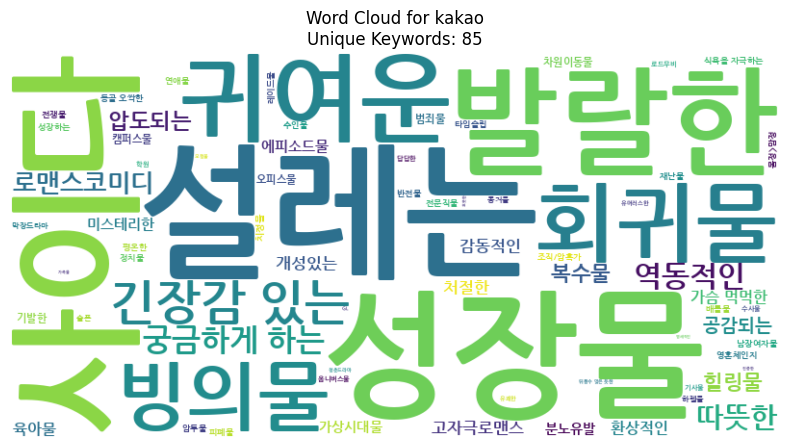

Platform: kakao
Unique Keywords: 85



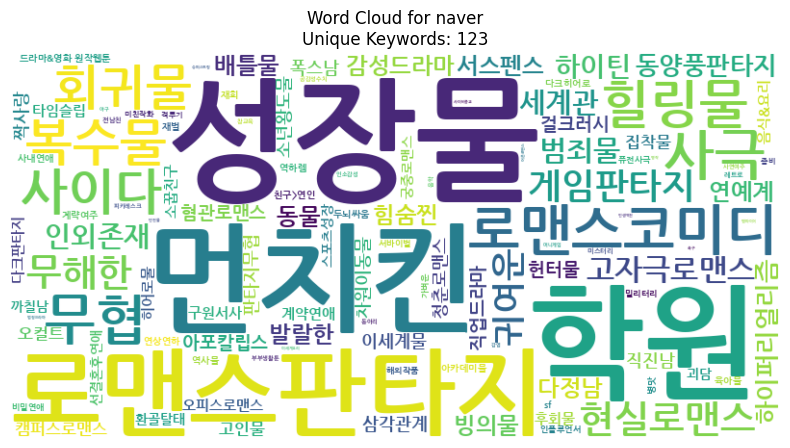

Platform: naver
Unique Keywords: 123



In [250]:
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 플랫폼별 키워드 카운트 함수 정의
def count_keywords_by_platform(df, platform_column, keywords_column):
    # 플랫폼별 그룹화
    platform_groups = df.groupby(platform_column)

    # 플랫폼별 키워드 카운트 저장할 딕셔너리
    platform_keywords_count = {}

    for platform, group in platform_groups:
        # 키워드 리스트 합치기
        all_keywords = []
        for keywords in group[keywords_column]:
            if keywords:
                all_keywords.extend([keyword.strip() for keyword in keywords.split(',')])

        # 키워드 카운트
        keyword_counts = Counter(all_keywords)

        # 플랫폼별 키워드 카운트 저장
        platform_keywords_count[platform] = keyword_counts

    return platform_keywords_count

# 키워드 카운트 결과 얻기
platform_keywords_count = count_keywords_by_platform(df2, 'plat', 'Filtered_Keywords')

# 각 플랫폼별로 워드 클라우드 생성 및 시각화
for platform, keyword_counts in platform_keywords_count.items():
    # 총 고유 키워드 개수 계산
    unique_keywords_count = len(keyword_counts)

    # 워드 클라우드 생성
    wordcloud = WordCloud(
        font_path="/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf",  # 한글 폰트 경로 (필요 시 변경)
        width=800,
        height=400,
        background_color='white'
    ).generate_from_frequencies(keyword_counts)

    # 워드 클라우드 출력
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # 축 제거
    plt.title(f'Word Cloud for {platform}\nUnique Keywords: {unique_keywords_count}')  # 플랫폼 제목 및 고유 키워드 개수 추가
    plt.show()

    # 총 고유 키워드 개수 출력
    print(f"Platform: {platform}")
    print(f"Unique Keywords: {unique_keywords_count}\n")


## 2-2 Keywords_from_story 생성

### 2-2-1 형태소 분석기 2개 비교

#### (1) 후보1: Kkma

In [251]:
!pip install konlpy

In [252]:
from konlpy.tag import Okt
import re

def split_noun_sentences(text):
    okt = Okt()
    sentences = text.replace(". ",".")
    sentences = re.sub(r'([^\n\s\.\?!]+[^\n\.\?!]*[\.\?!])', r'\1\n', sentences).strip().split("\n")

    result = []
    for sentence in sentences:
        if len(sentence) == 0:
            continue
        sentence_pos = okt.pos(sentence, stem=True)
        nouns = [word for word, pos in sentence_pos if pos == 'Noun']
        if len(nouns) == 1:
            continue
        result.append(' '.join(nouns) + '.')

    return result

In [253]:
df2["Story_clean_noun"] = df2["Story_clean1"].apply(split_noun_sentences)

In [254]:
!pip install krwordrank

In [255]:
from konlpy.tag import Kkma
from krwordrank.word import KRWordRank

# 형태소 분석기를 사용하여 NNG(일반 명사)와 XR(어근)만 남기기
def filter_nouns_and_roots(keywords):
    kkma = Kkma()
    filtered_keywords = {}
    for word, rank in keywords.items():
        pos_tags = kkma.pos(word)
        print(f"'{word}': {pos_tags}")  # 각 단어의 품사 태그를 출력
        if any(pos in ['NNG', 'XR'] for _, pos in pos_tags):  # NNG, XR에 해당하는 경우만 포함
            filtered_keywords[word] = rank
    return filtered_keywords

def extract_keywords(texts, min_count=1, max_length=10, beta=0.85, max_iter=20):
    wordrank_extractor = KRWordRank(min_count=min_count, max_length=max_length)
    if isinstance(texts, list):
        texts = [' '.join(texts)]  # 리스트를 하나의 문자열로 결합
    keywords, rank, graph = wordrank_extractor.extract(texts, beta, max_iter)
    return keywords

text = df2["Story_clean_noun"][0]

# 키워드 추출
keywords = extract_keywords(text)

# 상위 10개의 키워드 추출
top_10_keywords = dict(sorted(keywords.items(), key=lambda x: x[1], reverse=True)[:10])

# NNG(일반 명사)와 XR(어근)만 남기기
filtered_keywords = filter_nouns_and_roots(top_10_keywords)

# 결과 출력
print("Filtered Keywords:")
for word, rank in sorted(filtered_keywords.items(), key=lambda x: x[1], reverse=True):
    print('%8s:\t%.4f' % (word, rank))


'자신': [('자신', 'NNG')]
'때문': [('때문', 'NNB')]
'첫사랑': [('첫사랑', 'NNG')]
'섹스': [('섹스', 'NNG')]
'민정': [('민정', 'NNG')]
'연습': [('연습', 'NNG')]
'사실': [('사실', 'NNG')]
'한결': [('한결', 'MAG')]
'스킨십.': [('스킨십', 'NNG'), ('.', 'SF')]
'무성': [('무성', 'XR')]
Filtered Keywords:
      자신:	2.3523
     첫사랑:	1.6105
      섹스:	1.4682
      민정:	1.3440
      연습:	1.2698
      사실:	1.1664
    스킨십.:	1.1171
      무성:	1.0585


#### (2) 후보2: Komoran

In [256]:
from konlpy.tag import Komoran
from krwordrank.word import KRWordRank

# 형태소 분석기를 사용하여 고유명사(NNP)와 대명사(NP)만 제거
def remove_proper_nouns_and_pronouns(keywords):
    komoran = Komoran()
    filtered_keywords = {}
    for word, rank in keywords.items():
        pos_tags = komoran.pos(word)
        print(f"'{word}': {pos_tags}")  # 각 단어의 품사 태그를 출력
        if not any(pos in ['NNP', 'NP'] for _, pos in pos_tags):  # 고유명사(NNP), 대명사(NP)가 아닌 경우만 포함
            filtered_keywords[word] = rank
    return filtered_keywords

def extract_keywords(texts, min_count=1, max_length=10, beta=0.85, max_iter=20):
    wordrank_extractor = KRWordRank(min_count=min_count, max_length=max_length)
    if isinstance(texts, list):
        texts = [' '.join(texts)]  # 리스트를 하나의 문자열로 결합
    keywords, rank, graph = wordrank_extractor.extract(texts, beta, max_iter)
    return keywords

# 예제 텍스트
text = df2["Story_clean_noun"][0]

# 키워드 추출
keywords = extract_keywords(text)

# 상위 10개의 키워드 추출
top_10_keywords = dict(sorted(keywords.items(), key=lambda x: x[1], reverse=True)[:10])

# 고유명사(NNP)와 대명사(NP) 제거
filtered_keywords = remove_proper_nouns_and_pronouns(top_10_keywords)

# 결과 출력
print("Filtered Keywords:")
for word, rank in sorted(filtered_keywords.items(), key=lambda x: x[1], reverse=True):
    print('%8s:\t%.4f' % (word, rank))

'자신': [('자신', 'NNG')]
'때문': [('때문', 'NNB')]
'첫사랑': [('첫사랑', 'NNP')]
'섹스': [('섹스', 'NNP')]
'민정': [('민정', 'NNP')]
'연습': [('연습', 'NNG')]
'사실': [('사실', 'NNG')]
'한결': [('한결', 'MAG')]
'스킨십.': [('스킨', 'NNP'), ('십', 'NR'), ('.', 'SF')]
'무성': [('무성', 'NNP')]
Filtered Keywords:
      자신:	2.3523
      때문:	1.6613
      연습:	1.2698
      사실:	1.1664
      한결:	1.1192


### 2-2-2 Kkma 채택

In [257]:
import pandas as pd
from konlpy.tag import Kkma
from krwordrank.word import KRWordRank

# 형태소 분석기를 사용하여 NNG(일반 명사)와 XR(어근)만 남기기
def filter_nouns_and_roots(keywords):
    kkma = Kkma()
    filtered_keywords = []
    for word, rank in keywords.items():
        pos_tags = kkma.pos(word)
        if any(pos in ['NNG', 'XR'] for _, pos in pos_tags):  # NNG, XR에 해당하는 경우만 포함
            filtered_keywords.append(word)
    return filtered_keywords

def extract_keywords(texts, min_count=1, max_length=10, beta=0.85, max_iter=20):
    wordrank_extractor = KRWordRank(min_count=min_count, max_length=max_length)
    if isinstance(texts, list):
        texts = [' '.join(texts)]  # 리스트를 하나의 문자열로 결합
    keywords, rank, graph = wordrank_extractor.extract(texts, beta, max_iter)
    return keywords

# 전체 데이터 프레임에 적용
def process_texts(df, column_name):
    filtered_keywords_list = []
    for text in df[column_name]:
        # 키워드 추출
        keywords = extract_keywords(text)
        # 상위 10개의 키워드 추출
        top_10_keywords = dict(sorted(keywords.items(), key=lambda x: x[1], reverse=True)[:10])
        # NNG(일반 명사)와 XR(어근)만 남기기
        filtered_keywords = filter_nouns_and_roots(top_10_keywords)
        # 필터링된 키워드 저장
        filtered_keywords_list.append(filtered_keywords)
    return filtered_keywords_list



# 새로운 열에 필터링된 키워드 저장
df2["Keywords_from_story"] = process_texts(df2, "Story_clean_noun")



In [258]:
df2["Keywords_from_story"]

0              [자신, 첫사랑, 섹스, 민정, 연습, 사실, 스킨십., 무성]
1       [가문, 가주, 아버지, 한번, 제국, 황자, 금수, 티아, 피렌, 사생아]
2                        [사랑, 일생, 그레이, 인생, 소녀, 여자]
3             [정현, 예은, 사이, 직장, 마음, 눈치, 선미, 그때, 이름]
4             [가게, 도시락, 식용, 윤아, 소아, 돈가스, 항의, 샌드위치]
                           ...                    
2248              [작사, 유성, 생각, 최애, 회사, 연예, 무명, 남자]
2249      [서울, 연우, 세포, 수학, 평소, 감염, 순간, 불명, 접촉, 여행]
2250                  [취향, 학년, 유진, 생각, 속마, 여고, 고등]
2251     [번의, 지구, 태오, 청소, 불명, 대도시, 불시, 재난, 기존, 사건]
2252     [아버지, 식물인간, 수감, 조폭, 교도소, 장악., 복수, 소꿉, 소년]
Name: Keywords_from_story, Length: 2253, dtype: object

In [259]:
# .으로 끝나는 단어에서 .을 제거하는 함수
def remove_period_from_keywords(keywords):
    return [keyword.rstrip('.') for keyword in keywords]

# df2["Keywords_from_story"] 열에 함수 적용
df2["Keywords_from_story"] = df2["Keywords_from_story"].apply(remove_period_from_keywords)

# 수정된 결과 확인
print(df2["Keywords_from_story"].head())

0            [자신, 첫사랑, 섹스, 민정, 연습, 사실, 스킨십, 무성]
1    [가문, 가주, 아버지, 한번, 제국, 황자, 금수, 티아, 피렌, 사생아]
2                     [사랑, 일생, 그레이, 인생, 소녀, 여자]
3          [정현, 예은, 사이, 직장, 마음, 눈치, 선미, 그때, 이름]
4          [가게, 도시락, 식용, 윤아, 소아, 돈가스, 항의, 샌드위치]
Name: Keywords_from_story, dtype: object


### 2-2-3 플랫폼 별 스토리 키워드 TOP 25

In [260]:
# 플랫폼 별 스토리에서 뽑은 키워드의 TOP 25

from collections import Counter
# 플랫폼별 키워드 카운트 함수 정의
def count_keywords_by_platform(df, platform_column, keywords_column):
    # 플랫폼별 그룹화
    platform_groups = df.groupby(platform_column)

    # 플랫폼별 키워드 카운트 저장할 딕셔너리
    platform_keywords_count = {}

    for platform, group in platform_groups:
        # 키워드 리스트 합치기
        all_keywords = sum(group[keywords_column], [])

        # 키워드 카운트
        keyword_counts = Counter(all_keywords)

        # 플랫폼별 키워드 카운트 저장
        platform_keywords_count[platform] = keyword_counts

    return platform_keywords_count

# 키워드 카운트 결과 얻기
platform_keywords_count = count_keywords_by_platform(df2, 'plat', 'Keywords_from_story')

# 결과 출력
for platform, keyword_counts in platform_keywords_count.items():
    print(f"Platform: {platform}")
    for keyword, count in keyword_counts.most_common(25):
        print(f"  {keyword}: {count}")
    print("\n")

Platform: kakao
  시작: 146
  자신: 109
  남자: 104
  사람: 94
  사랑: 89
  세계: 87
  결혼: 81
  게임: 70
  소설: 66
  주인공: 64
  죽음: 57
  세상: 55
  황제: 51
  공작: 50
  가문: 49
  인간: 49
  여자: 48
  생각: 48
  인생: 46
  이야기: 45
  아이: 43
  주인: 43
  제국: 41
  회귀: 41
  마음: 39


Platform: naver
  시작: 117
  사람: 59
  자신: 57
  세상: 49
  세계: 48
  남자: 47
  사랑: 46
  작가: 45
  이야기: 44
  인간: 35
  결혼: 34
  복수: 34
  로맨스: 34
  게임: 32
  인생: 32
  소년: 30
  아이: 27
  학교: 27
  능력: 27
  판타지: 27
  죽음: 24
  최강: 23
  연애: 22
  주인공: 21
  현실: 21




### 2-2-4 플랫폼 별 스토리 키워드 워드 클라우드

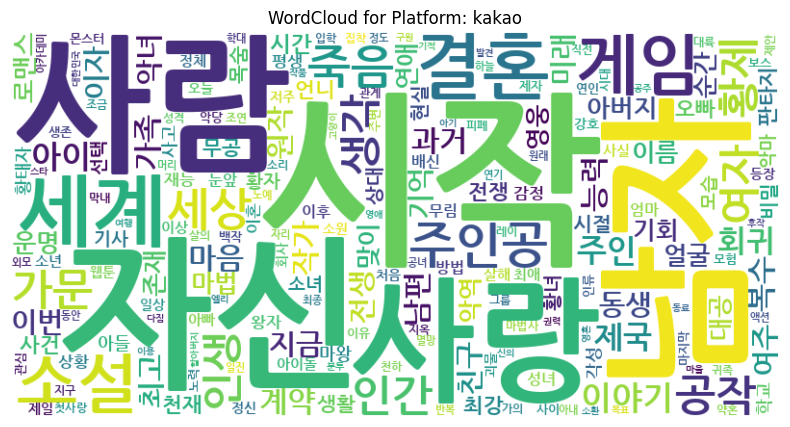

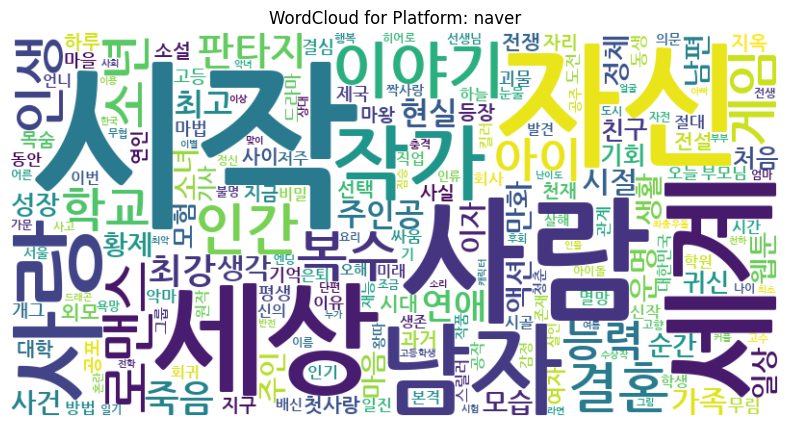

In [261]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# 한글 폰트 경로 설정 (시스템에 맞게 변경 필요)
font_path = "/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf"

# 키워드 카운트 결과 얻기
platform_keywords_count = count_keywords_by_platform(df2, 'plat', 'Keywords_from_story')

# 플랫폼별 모든 키워드를 포함한 워드클라우드 생성
for platform, keyword_counts in platform_keywords_count.items():
    # 워드클라우드 생성
    wordcloud = WordCloud(
        font_path=font_path,
        width=800,
        height=400,
        background_color='white',
        colormap='viridis'
    ).generate_from_frequencies(keyword_counts)

    # 워드클라우드 시각화
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"WordCloud for Platform: {platform}")
    plt.axis('off')
    plt.show()


# 3. 추천시스템

In [144]:
df2.columns

Index(['Title', 'Story', 'Keywords', 'Likes', 'Link', 'Day', 'Rank',
       'Story_clean', 'Story_clean1', 'Story_clean2', 'cluster8', 'Likes_log',
       'Likes_normalized', 'Original_Genre', 'Genre_드라마', 'Genre_로맨스',
       'Genre_스릴러', 'Genre_액션/무협/사극', 'Genre_코믹/일상', 'Genre_판타지', 'Genre',
       'Original_plat', 'plat_kakao', 'plat_naver', 'plat', 'Age_19',
       'Is_Complete', 'Filtered_Keywords', 'Story_clean_noun',
       'Keywords_from_story'],
      dtype='object')

In [263]:
text_features = ['Filtered_Keywords']
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = np.hstack([tfidf_vectorizer.fit_transform(df2[feature]).toarray() for feature in text_features])

additional_text_feature = 'Keywords_from_story'
additional_tfidf_vectorizer = TfidfVectorizer(max_features=5000)
additional_tfidf_matrix = additional_tfidf_vectorizer.fit_transform(df2[additional_text_feature].apply(lambda x: ' '.join(x))).toarray()


genre_features = df2[['Genre_드라마', 'Genre_로맨스', 'Genre_스릴러',
       'Genre_액션/무협/사극', 'Genre_코믹/일상', 'Genre_판타지']].to_numpy()

day_features = df2['Is_Complete'].to_numpy().reshape(-1, 1)
age_features = df2['Age_19'].to_numpy().reshape(-1, 1)

plat_features = df2[['plat_kakao', 'plat_naver']].to_numpy()

cluster_features = df2['cluster8'].to_numpy().reshape(-1, 1)

numerical_features = df2[['Likes_normalized', 'Rank']].to_numpy()


In [287]:
# 가중치 설정
weight_tfidf = 0.3
weight_genre = 0.4
weight_age = 0.3
weight_day = 0.00
weight_cluster = 0.15
weight_numerical = 0.3
weight_additional_text = 0.15

#가중치 적용
tfidf_weighted = tfidf_matrix * weight_tfidf
additional_tfidf_weighted = additional_tfidf_matrix * weight_additional_text
genre_weighted = genre_features * weight_genre
age_weighted = age_features * weight_age
day_weighted = day_features * weight_day
cluster_weighted = cluster_features * weight_cluster
# plat_weighted = plat_features * weight_plat
numerical_weighted = numerical_features * weight_numerical

# 피처 벡터 결합
weighted_features = np.hstack([genre_weighted, age_weighted, day_weighted,  numerical_weighted, cluster_weighted, tfidf_weighted, additional_tfidf_weighted])

# 유사도 계산
similarity_matrix_weighted = cosine_similarity(weighted_features)


In [288]:
# 추천 함수
def get_recommendations(title, similarity_matrix, df):
    idx = df.index[df['Title'] == title].tolist()[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    item_indices = [i[0] for i in sim_scores]
    columns_to_return = ['Title', 'Genre', 'Story','Age_19', 'plat','cluster8']
    return df.iloc[item_indices][columns_to_return]


In [289]:
get_recommendations('연애혁명',similarity_matrix_weighted, df2)

,Title,Genre,Story,Age_19,plat,cluster8
2199,갑!자기 건물주,드라마,갑자기 건물주가 되어버린 대학생 김가비. 그녀의 운명을 바꾸고 사라졌던 남자 이지을...,False,naver,3
1824,결혼 시뮬레이션,드라마,"가까운 미래. 점점 떨어지는 혼인율, 감소하는 인구. 결혼은 더 이상 사랑이 아닌 ...",False,naver,3
2122,율리,드라마,신의 사원의 대도서관 관장인 쿠무치는 한 노예시장에서 율리라는 이름의 아이를 데려온...,False,naver,7
1853,두 마리를 위한 뜰,드라마,잡아먹어달라고! 평화롭던 산양마을에서 한순간 불길한 징조가 되어버린 우이람. 모든...,False,naver,6
1443,밥 먹고 갈래요?,드라마,이리 뛰고 저리 뛰고 깨지고 구르고. 지칠대로 지친 주중을 보내고 나면 찾아오는 ...,False,naver,5
2048,애증화음,드라마,치열하게 경쟁하는 서화예술고등학교 피아노과의 두 여학생 최인정과 선경화. 중학교 ...,False,naver,6
2141,솔직하게 말해줘!,드라마,'우리는 말할 때 어떤 '필터'를 쓸까?' 소심한 성격탓에 늘 속내를 숨기고 살던 ...,False,naver,6
1637,여고생이 신인데 나만 괴롭힘,드라마,"그냥 인생이 재수 없는 줄 알았는데, 알고 보니 여고생이 내 인생을 조작해서 괴롭히...",False,naver,4
1659,나의 보이소프렌드,드라마,피아노 천재인 신비는 한 때 천재 보이소프라노인 태의와 오랫동안 합을 맞춰왔다. 어...,False,naver,5
1756,동경과 거짓말,드라마,"음악을 순수히 동경하는 편입생, 에델바이스 밀런. 그러나 음악 학원에 계속해서 다니...",False,naver,6


In [290]:
get_recommendations('작전명 순정',similarity_matrix_weighted, df2)

,Title,Genre,Story,Age_19,plat,cluster8
2166,날 닮은 아이,로맨스,청혼을 앞두고 기억을 잃은 남자 정지헌. 그에게 실연당했다고 믿는 여자 이정오. 두...,False,naver,3
12,녹음의 관,로맨스,남자주인공에게 트라우마를 남긴 계모의 딸에 빙의했다. 이 모든 것은 내가 열 다섯 ...,False,kakao,5
1399,아슈타르테,로맨스,"무한한 영광을 가져다줄 피렌체 제국의 빛,아슈타르테. 하지만 음모로 인해 예언은 뒤...",False,naver,5
10,내 남자의 청첩장,로맨스,스무 살 '예은'은 잘생긴 '정현'과 사귀며 20대 청춘을 불태우지만 서른 살이 되...,False,kakao,4
17,그녀와 야수,로맨스,"제국의 시조였던 전설적인 인물 마티나의 죽음으로부터 백 년 후, 마티나는 귀족가의 ...",False,kakao,5
14,그 책에 마음을 주지 마세요,로맨스,로맨스 피폐 소설 「루스벨라의 빛」 엑스트라인 황제의 여덟 번째 황녀로 환생에 새로...,False,kakao,4
632,"남주님, 취향 존중해드릴게요",로맨스,피폐 BL <폭군의 은사꽃>에 빙의해 버렸다. 그것도 두 주인공의 역사적인 거사가...,False,kakao,4
634,내 남자 주인공의 아내가 되었다,로맨스,남주 여주 커플의 아름다운 사랑으로 저주받은 용과 마물 그리고 최종 보스의 영혼까지...,False,kakao,4
1099,집착 서브 남주가 미쳐 날뛴다,로맨스,동제국 브뤼케 가문의 딸 '루루티에'. 죽은 어머니를 부활시키기 위한 마법실험의 희...,False,kakao,5
628,악역의 엔딩은 죽음뿐,로맨스,"역하렘 공략 게임의 악역, 에카르트 공작가의 하나뿐인 공녀이자 입양아 페넬로페...",False,kakao,4


In [291]:
get_recommendations('언니, 이번 생엔 내가 왕비야',similarity_matrix_weighted, df2)

,Title,Genre,Story,Age_19,plat,cluster8
958,점괘보는 공녀님,로맨스,'귀신 보는 능력을 가진 탑배우 이시아. 사고 후 ‘카밀라 소르펠’의 몸에서 눈을 ...,False,kakao,5
323,쉬고 싶은 레이디,로맨스,"왕, 마법사, 악사, 검사, 부호, 거지, 성녀, 마녀... 수없이 전생을 거듭하며...",False,kakao,3
798,악당의 소중한 따님,로맨스,성녀를 닮았다는 이유로 억울하게 납치되어 살해되는 운명인 줄 알았다. 다시 악당 공...,False,kakao,5
1399,아슈타르테,로맨스,"무한한 영광을 가져다줄 피렌체 제국의 빛,아슈타르테. 하지만 음모로 인해 예언은 뒤...",False,naver,5
2061,세레나,로맨스,"""너는 절대로 내 세레니티의 주인이 될 수 없어."" 세레니티 가문의 유일한 상속자...",False,naver,6
12,녹음의 관,로맨스,남자주인공에게 트라우마를 남긴 계모의 딸에 빙의했다. 이 모든 것은 내가 열 다섯 ...,False,kakao,5
1095,흑막의 어린 후원자,로맨스,"장기 말로 살다 비참하게 죽을 악녀, 다프네로 환생했다. 원작처럼 죽지 않고 자유롭...",False,kakao,3
628,악역의 엔딩은 죽음뿐,로맨스,"역하렘 공략 게임의 악역, 에카르트 공작가의 하나뿐인 공녀이자 입양아 페넬로페...",False,kakao,4
955,빙의자를 위한 특혜,로맨스,※사후 세계를 대비하세요! 죽기 직전에 받은 이상한 스팸문자. 죽은 줄 알고 눈떠...,False,kakao,3
10,내 남자의 청첩장,로맨스,스무 살 '예은'은 잘생긴 '정현'과 사귀며 20대 청춘을 불태우지만 서른 살이 되...,False,kakao,4


In [292]:
get_recommendations('이 결혼은 어차피 망하게 되어 있다 [19세 완전판]',similarity_matrix_weighted, df2)

,Title,Genre,Story,Age_19,plat,cluster8
792,공작 부인은 하고 싶어도 [19세 완전판],로맨스,엘마노 공작과 결혼식을 올린 지 한 달이 넘어가는데도 라리엘라는 아직 초야를 치르지...,True,kakao,5
4,맛있는 세 끼 - 저스트 더 투 오브 어스 [19세 완전판],로맨스,"S대 병원 소아 응급실을 지배하는 폭군, 차수혁. 환자를 제외한 모든 것들에 까칠하...",True,kakao,7
6,세이렌: 악당과 계약 가족이 되었다,로맨스,"아리아는 계약 결혼을 제안했다. 그것도, 악마에게 영혼을 팔았다는 발렌타인의 대공자...",False,kakao,7
1087,공녀는 지금부터 파업합니다,로맨스,"공작가의 사생아로 자란 공녀, 아르릴 프레이 브릭시아. 붉은 눈동자와 검은 반점으...",False,kakao,7
320,"여보, 나 파업할게요 [19세 완전판]",로맨스,"2회차 결혼 생활, 돌연 파업 선언?! 결혼 생활 10년 동안 무뚝뚝하고 전쟁밖에...",True,kakao,4
162,결혼 장사 [19세 완전판],로맨스,"사치스러운 악처, 비앙카 드 아르노. 모두에게 버림받고 죽어가던 그때, 비앙카는 기...",True,kakao,5
168,악녀는 마리오네트,로맨스,"""아름다움은 진짜 권력이 될 수 없다."" 제국에서 가장 아름답다 칭송받지만, 사...",False,kakao,7
790,"구애, 여우를 홀리다",로맨스,혼롓날 급작스럽게 들이닥친 요물로 인해 정인을 잃고 납치당해 능욕을 당한 예화. 그...,True,kakao,5
625,시한부를 즐겼을 뿐이었는데,로맨스,"시한부였던 나, 빙의도 시한부 캐릭터에 해버렸다? 비록 이번에도 시한부지만 오늘내...",False,kakao,7
1090,열애의 품격,로맨스,“숨바꼭질은 재미있었습니까? 술래는 제 취향이 아니더라고요.” 정의일보 최...,False,kakao,7


In [293]:
get_recommendations('이 결혼은 어차피 망하게 되어 있다',similarity_matrix_weighted, df2)

,Title,Genre,Story,Age_19,plat,cluster8
560,당신이 사랑하는 동안에,로맨스,"아슬란의 아내로 지냈던 3년. 그에게 어울리는 여자가 되려고 무던히 노력했으나, 그...",False,kakao,0
553,그래서 나는 폐태자와 결혼했다,로맨스,연인에게 배신 당하고 아이까지 빼앗긴 내게 두 번째 기회가 주어졌다. ‘모든 걸 ...,False,kakao,0
1839,선배는 나빠요!,로맨스,오직 나쁜 남자에게만 매력을 느껴 현실에선 연애 한번 해본 적 없는 '릴리'. 본인...,False,naver,0
69,아도니스,로맨스,"자신과 누구보다 닮았던 자, 그래서 서로에게만 집중했고 광적으로 집착했다. 다만 ...",False,kakao,1
237,번데기 속 고양이,로맨스,"""다시는 당신을 죽게 하지 않을 거예요."" 제럴드 후작가의 잡음이라 불리며 구박데...",False,kakao,2
2106,완벽한 부부는 없다,로맨스,남편의 이혼 요구를 피하고 싶은 연화는 갑작스러운 사고 후 기억을 잃은 척 연기하게...,False,naver,1
2043,3분의 1이 없어도,로맨스,＂서른에도 솔로면 우리끼리 결혼하자!＂ 철없는 중학생 때 소꿉친구와 장난처럼 했던 ...,False,naver,0
688,가짜 애첩의 화려한 일상,로맨스,"""이번 생엔 절대 당신을 사랑하지 않을 거야!"" 지독히도 사랑했던 에스테반 공작의...",False,kakao,1
1218,적기사는 눈먼 돈을 좇지 않는다,로맨스,"회귀 후, 흑기사였던 과거를 버리고 적기사가 된 유디트. 이번 생은 후회하지 않...",False,kakao,0
231,리셋팅 레이디,로맨스,어느 날 갑자기 책 속으로 들어왔다. 진정한 사랑에 빠지면 현실로 돌아올 수 있을...,False,kakao,1


In [294]:
get_recommendations('재혼 황후',similarity_matrix_weighted, df2)

,Title,Genre,Story,Age_19,plat,cluster8
2181,피폐물 남주의 엄마가 되었다,로맨스,눈을 떠보니 피도 눈물도 없는 피폐물 소설 속 남주의 엄마 ‘셰리엘’이 되었다. 원...,False,naver,6
1609,북부 공작님을 유혹하겠습니다,로맨스,"“내 애인인 척 사교계에 들어가.” 전 세계에서 주목하는 톱스타, 셀리나는 촬영 중...",False,naver,7
492,눈이 나려 꽃,로맨스,"설석은 지방 하급관리의 딸로, 영민하고 눈치가 좋아 그 지방 상대부의 정실인 위 부...",False,kakao,7
819,가짜 성녀인데 신들이 집착한다,로맨스,"5년 뒤, 진짜 성녀가 나타나면 죽게 될 가짜 성녀에게 빙의했다. 성녀에게 떨어지...",False,kakao,7
192,맛볼 수 없는 남자,로맨스,"""그 혀를 날 위해 써줘."" 인기 소설가 이인우의 자문을 부탁받은 푸드 칼럼니스트...",False,kakao,7
1113,아기 성녀님은 세상을 멸망시키고 싶어!,로맨스,"대륙의 재앙이라 불리는 위대한 마녀, 루시펠라. 99번의 환생에 지친 그녀는 세상을...",False,kakao,7
498,Oh! 마이 서방님,로맨스,"*이 작품은 가상의 조선을 배경으로 하는 퓨전사극이며, 작품에 등장하는 인물 및 설...",False,kakao,7
25,비선실세 레이디,로맨스,역하렘 소설 속 여주인공의 하나뿐인 동생으로 빙의했다. 게다가 한 번 크케 앓다 깨...,False,kakao,6
642,"다시 한번, 빛 속으로",로맨스,성녀로 추앙 받는 동생을 죽이려고 했다는 누명을 썼다. 나를 믿어주는 사람 하나 없...,False,kakao,6
815,우리가 가족이 될 수 있을까요?,로맨스,"아그니스 공작의 시한부 딸을 대신하여 황태자와 결혼하기 위해 입양된, '나비아 아그...",False,kakao,6


In [295]:
get_recommendations('화산귀환',similarity_matrix_weighted, df2)

,Title,Genre,Story,Age_19,plat,cluster8
1678,김부장,액션/무협/사극,“제발 안경 쓴 아저씨는 건들지 말자…” 오직 자신의 딸 '민지'를 위해 특수요원직...,False,naver,5
316,천광명월,액션/무협/사극,강자만이 살아남는 무림전국시대. 전쟁노예 천광과 중원제일의 기생 명월의 무림 생존기...,False,kakao,6
1585,참교육,액션/무협/사극,무너진 교권을 지키기 위해 교권보호국 소속 나화진의 참교육이 시작된다! <부활남> ...,False,naver,5
1384,광마회귀,액션/무협/사극,무공에 미친 광마 이자하. 그는 마교 교주의 천옥을 훔쳐 쫓기던 중 벼랑에서 떨어지...,False,naver,3
1867,나노마신,액션/무협/사극,"갖은 멸시와 목숨의 위협을 받던 마교의 사생아 천여운, 미래에서 나타난 후손이 천...",False,naver,4
2153,배달왕,드라마,“내가 뭘 배달 한 거지?!“ 팍팍한 생활고를 벗어나기 위해 고액 배달알바를 한 ...,False,naver,7
1,이번 생은 가주가 되겠습니다,로맨스,"“…한번 해 보자. 내가 가주가 되는 거야.” 제국에서 제일가는 가문, 롬바르디...",False,kakao,7
1085,왕의 공녀,로맨스,[ 마계에 공물로 바친다. ] 시리어스 제국에 떨어진 갑작스러운 황명. 영문을 ...,False,kakao,7
1385,2024 내일 뭐 입지?,코믹/일상,'옷은 많은데.. 왜 맨날 입을 옷이 없지..???' 최애캐가 골라주는 내일의 코디!,False,naver,6
161,나쁜 X [19세 완전판],로맨스,‘진실한 사랑이란 게 정말 있을까?’ 일이건 연애건 자신의 앞길은 자신이 개척할 ...,True,kakao,7


In [296]:
get_recommendations('가비지타임',similarity_matrix_weighted, df2)

,Title,Genre,Story,Age_19,plat,cluster8
1759,렌탈히어로,액션/무협/사극,자리를 비운 히어로들 대신 일반인 행세를 하는 도플갱어 이주원. 그에게 히어로 랭킹...,False,naver,5
1512,더 복서,액션/무협/사극,재능있는 복서를 찾던 전설적인 트레이너 K는 기묘한 소년을 발견한다. 그의 충격적인...,False,naver,7
1488,광장,액션/무협/사극,‘군계일학’ 정점에서 조직을 떠난 기준. 15년만에 홀로 복귀한다.,False,naver,7
2144,이매망량,액션/무협/사극,"사람을 해치는 악귀 이매망량이 본격적으로 활개를 펼치기 시작한 조선, 전 국토 곳곳...",False,naver,5
1475,브레이커 : 이터널 포스,액션/무협/사극,전설급 현대무협 도시액션이 시작된다. 괴롭힘에 옥상에서 죽음을 고민하고 있는 하제....,False,naver,6
109,천마를 삼켰다,액션/무협/사극,"40년 전, 지구에 떨어진 의문의 세 개의 씨앗으로 수많은 괴물이 쏟아져 나왔다. ...",False,kakao,7
2252,소년교도소,액션/무협/사극,"조폭인 아버지를 식물인간으로 만들어 소년교도소에 수감된 ‘차주영’. 얼마 뒤, 깨어...",False,naver,7
1059,검은 머리 전술 천재,액션/무협/사극,3부 K-리그 전략분석관인 주인공 마정우. 나날이 늘어나기만 하는 빚에 시달리던...,False,kakao,6
1828,좀간,액션/무협/사극,"모두가 살기 위해 발버둥 치는 세상 속, 유일하게 죽음을 원하는 소년, 온미래. 어...",False,naver,4
2151,나만 최강 초월자,액션/무협/사극,"뛰어난 신체 능력과 특수한 능력을 겸비한 ""초월자""가 존재하는 세계. 따돌림 속에서...",False,naver,6


In [297]:
get_recommendations('똑 닮은 딸',similarity_matrix_weighted, df2)

,Title,Genre,Story,Age_19,plat,cluster8
1776,내 여자친구는,스릴러,여자친구가 사람을 잡아먹는 것을 목격한 주인공. 그럴 리가 없어. 현실 부정을 하는...,False,naver,6
2155,기기괴괴2,스릴러,돌아온 오성대 작가의 기묘하고 괴상한 이야기들! 잊고 있던 공포라는 감정을 다시 느...,False,naver,4
5,BLOCK,스릴러,"""나는 해결사다. 그리고 오늘... 첫 임무를 시작한다."" 킬러가 되기 위해 휴학...",False,kakao,6
1679,좋아? 죽어!,스릴러,남자들이면 한번쯤 뒤돌아볼만한 예쁜 외모를 가진 '민주' 그녀의 직업은 인터넷 방송...,True,naver,5
2156,하자인간,스릴러,바람 핀 약혼자 창수 그걸 알고도 창수와 결혼하려는 수현 그리고 저도 모르게 상간녀...,True,naver,4
1869,촉법소년,액션/무협/사극,대한민국은 X같은 법들로 가득하다 나를 지옥으로 밀어넣고도 처벌받지 않았던 ‘촉법소...,False,naver,6
1589,윈드브레이커,액션/무협/사극,혼자서 자전거를 즐겨타던 모범생 조자현. 원치 않게 자전거 크루의 일에 자꾸 휘말리...,False,naver,7
1681,내가 키운 S급들,판타지,F급 헌터. 그것도 잘나가는 S급 동생 발목이나 잡는 쓸모없고 찌질한 F급 형. 개...,False,naver,7
6,세이렌: 악당과 계약 가족이 되었다,로맨스,"아리아는 계약 결혼을 제안했다. 그것도, 악마에게 영혼을 팔았다는 발렌타인의 대공자...",False,kakao,7
1587,백수세끼,드라마,백수 시절 내 곁을 지켜줬던 그녀... 돌아와 주면 안 되겠니? 음식 메뉴마다 담겨...,False,naver,6


In [298]:
get_recommendations('미생',similarity_matrix_weighted, df2)

,Title,Genre,Story,Age_19,plat,cluster8
1544,사이다걸,드라마,"어느새 세상은 고구마밭이 되었다. 앞뒤 꽉꽉 막힌 사람, 대화가 통하지 않는 사람,...",False,naver,0
1259,취준진담,드라마,청년실업 100만 시대! 대학을 졸업했다는 이유만으로도 취업이 잘 되던 시절은 지...,False,kakao,2
1582,천치전능,드라마,학창 시절 매일 폭력 사건을 일으키던 문제아 김전지는 오토바이 사고로 다리를 다쳐 ...,False,naver,3
1356,신랑이 사라졌다,드라마,톱스타 진사랑의 사라진(?) 신랑을 되찾기 위한 고군분투 러브스토리! 광고 섭...,False,kakao,0
1573,킬더킹,드라마,"왕의 재능이란 무엇일까? 왕좌의 새로운 주인, 진정한 왕에 걸맞는 재능을 가려내는 ...",False,naver,1
1343,내게 볕이 닿지 않아도,드라마,미로와 유로는 세 살 터울 자매이다. 유로는 굵직굵직한 드라마 주인공의 아역으로 아...,False,kakao,3
1375,실패한 인생을 사는 데 성공했습니다,드라마,성공하면 장땡 아닌가요? 남의 불행을 전달하는 이른바 사이버 렉카 ‘엄지호(후드...,False,kakao,3
1557,이제 곧 죽습니다,드라마,아무래도 이번 생은 실패다. 죽음과 함께 시작된 13번의 새로운 삶,False,naver,3
1524,삼체,드라마,"나노 과학자 왕먀오. 어느날 그의 눈 앞에, 죽음의 카운트 다운이 보이기 시작한다....",False,naver,2
1382,당신과는 절대,드라마,섬에서 시어머니를 모시고 사는 정예는 가족에게 소홀한 시누이 염섭이 아무래도 마뜩잖...,False,kakao,4


In [300]:
get_recommendations('백수세끼',similarity_matrix_weighted, df2)

,Title,Genre,Story,Age_19,plat,cluster8
1388,올가미,드라마,"""일주일에 단 한 번, 내가 지시하는 곳으로 데려오기만 하면 돼요."" 정체불명의 힘...",False,naver,4
1593,소녀의 세계,드라마,완벽해 보이지만 사실 외로웠던 백조들과 맘씨 착한 오리가 만나 여러 갈등을 함께 겪...,False,naver,7
1389,2024 너네 뭐 먹니?,코믹/일상,"""우리가 뭘 먹는지 궁금해..?"" 웹툰 속 캐릭터들이 먹는 메뉴들을 소개합니다!",False,naver,6
2,더 그레이트,드라마,"언젠가는 꿈꾸는 소녀, 언젠가는 사랑을 하는 여자. 지금은 두 아이의 가장, 엄마...",False,kakao,3
957,부르다가 내가 죽을 여자뮤지션,드라마,남자와 10년째 평화롭게 연애하던 만화가 들빨개빨은 어느 날 우연히 만난 여성 뮤지...,True,kakao,7
1589,윈드브레이커,액션/무협/사극,혼자서 자전거를 즐겨타던 모범생 조자현. 원치 않게 자전거 크루의 일에 자꾸 휘말리...,False,naver,7
1869,촉법소년,액션/무협/사극,대한민국은 X같은 법들로 가득하다 나를 지옥으로 밀어넣고도 처벌받지 않았던 ‘촉법소...,False,naver,6
6,세이렌: 악당과 계약 가족이 되었다,로맨스,"아리아는 계약 결혼을 제안했다. 그것도, 악마에게 영혼을 팔았다는 발렌타인의 대공자...",False,kakao,7
625,시한부를 즐겼을 뿐이었는데,로맨스,"시한부였던 나, 빙의도 시한부 캐릭터에 해버렸다? 비록 이번에도 시한부지만 오늘내...",False,kakao,7
1090,열애의 품격,로맨스,“숨바꼭질은 재미있었습니까? 술래는 제 취향이 아니더라고요.” 정의일보 최...,False,kakao,7


In [301]:
get_recommendations('이번 생은 가주가 되겠습니다',similarity_matrix_weighted, df2)

,Title,Genre,Story,Age_19,plat,cluster8
1085,왕의 공녀,로맨스,[ 마계에 공물로 바친다. ] 시리어스 제국에 떨어진 갑작스러운 황명. 영문을 ...,False,kakao,7
1087,공녀는 지금부터 파업합니다,로맨스,"공작가의 사생아로 자란 공녀, 아르릴 프레이 브릭시아. 붉은 눈동자와 검은 반점으...",False,kakao,7
791,토끼와 흑표범의 공생관계,로맨스,18살이 지났음에도 아직도 사람으로 변하지 못한 채 새끼 토끼로 남아서 가문의 수치...,False,kakao,7
1086,더없이 완벽한 결혼,로맨스,오랫동안 짝사랑해 온 회사 대표 지훈에게 프러포즈를 받게 된 혜원. 로망 가득한 레...,False,kakao,7
162,결혼 장사 [19세 완전판],로맨스,"사치스러운 악처, 비앙카 드 아르노. 모두에게 버림받고 죽어가던 그때, 비앙카는 기...",True,kakao,5
790,"구애, 여우를 홀리다",로맨스,혼롓날 급작스럽게 들이닥친 요물로 인해 정인을 잃고 납치당해 능욕을 당한 예화. 그...,True,kakao,5
1084,"잘 가라, 내 인생",로맨스,"""사람을 죽였더니 썸남들이 생겼다."" 솔로 인생 5년차. 훈훈한 옆집 남자에게 들...",False,kakao,5
949,내가 버린 개에게 물렸을 때,로맨스,"윈터 공작가에선 개를 기른다. 주인에게 늘 순종하는 검은 개를.. 윈터가의 공녀,...",False,kakao,4
161,나쁜 X [19세 완전판],로맨스,‘진실한 사랑이란 게 정말 있을까?’ 일이건 연애건 자신의 앞길은 자신이 개척할 ...,True,kakao,7
0,관계 지향적 관계,로맨스,첫사랑과 1주년이 된 한결은 섹스가 불가능하다는 이유로 차이게 도니다. 실연의 아픔...,True,kakao,7


In [302]:
get_recommendations('세레나',similarity_matrix_weighted, df2)

,Title,Genre,Story,Age_19,plat,cluster8
170,나쁜 X,로맨스,‘진실한 사랑이란 게 정말 있을까?’ 일이건 연애건 자신의 앞길은 자신이 개척할 ...,False,kakao,5
803,나는 대놓고 신데렐라를 꿈꾼다,로맨스,드라마 외전 웹툰 <나는 대놓고 신데렐라를 꿈꾼다> 꽁냥꽁냥 애정만땅 연애를 한껏...,False,kakao,7
326,내 남자 주인공의 아내가 되었다,로맨스,남주 여주 커플의 아름다운 사랑으로 저주받은 용과 마물 그리고 최종 보스의 영혼까지...,False,kakao,7
12,녹음의 관,로맨스,남자주인공에게 트라우마를 남긴 계모의 딸에 빙의했다. 이 모든 것은 내가 열 다섯 ...,False,kakao,5
958,점괘보는 공녀님,로맨스,'귀신 보는 능력을 가진 탑배우 이시아. 사고 후 ‘카밀라 소르펠’의 몸에서 눈을 ...,False,kakao,5
798,악당의 소중한 따님,로맨스,성녀를 닮았다는 이유로 억울하게 납치되어 살해되는 운명인 줄 알았다. 다시 악당 공...,False,kakao,5
960,약탈★마드모아젤 [19세 완전판],로맨스,여기 한 남자가 있다. 왕도에서 가장 잘생긴 남자. 레니에 카발리에르 공작! 하...,True,kakao,6
1601,우아한 욕망,로맨스,늦은 밤 열린 호텔 엘리베이터. 그 안에는 오래 전 첫사랑이 중년 여성과 함께 있었...,True,naver,6
478,결혼 계약을 연장하는 방법 [19세 완전판],로맨스,작위를 물려받기 위해 결혼 상대를 찾던 백작가의 외동딸 에밀리. 그런 에밀리 앞에 ...,True,kakao,5
629,노이즈컴백,로맨스,가구디자인학과 4학년으로 복학한 '노이즈' 빡센 하루 일과를 완벽한 계획하에 철저히...,False,kakao,7


In [303]:
get_recommendations('쌉초의 난',similarity_matrix_weighted, df2)

,Title,Genre,Story,Age_19,plat,cluster8
1389,2024 너네 뭐 먹니?,코믹/일상,"""우리가 뭘 먹는지 궁금해..?"" 웹툰 속 캐릭터들이 먹는 메뉴들을 소개합니다!",False,naver,6
1685,유부 감자,코믹/일상,소개팅 첫날 결혼을 약속한 부부가 있다?! 아무것도 모르는 감자와 모든 것을 실천하...,False,naver,6
1683,마음의소리2,코믹/일상,"'마음의소리' 완결 후 3년, 조석 작가의 결코 소소하지 않은 일상(?) 대공개! ...",False,naver,3
2051,쌉초의 난,코믹/일상,"어디로 튈 지 모르는 무한 매력의 소유자 쌉초가 네이버웹툰에 불시착했다! ""헛웃음...",False,naver,3
1397,선천적 얼간이들,코믹/일상,뭘 해도 안되는 얼간이 신인류가 떴다! 낙천적 우유부단 거북이 가스파드와 말초적 친...,False,naver,7
1781,마음의소리(였던 것),코믹/일상,"""그리다 만화가 남아서 조금 더 넣었습니다"" 마음의소리가 될 뻔한(?) 더 짧고, ...",False,naver,4
165,딩스뚱스,코믹/일상,"토종 한국인 딩스와 뚱스, 타지에서 맨땅에 헤딩하기!",False,kakao,3
1785,진돌히디만화,코믹/일상,대학 CC로 만나 결혼까지 하고 웹툰작가까지 하다 뉴튜버까지 됐다? 동갑내기 부부 ...,False,naver,7
1391,무직백수 계백순,코믹/일상,"해둔 것도 없고, 스펙도 평범, 통장 잔고는 늘 만원 이하. 등골 브레이커 계백순은...",False,naver,3
1873,피부과 만렙남,코믹/일상,"여드름, 흉터, 모공으로 가득했던 울퉁불퉁 피부의 소유자 김달걀! 썸녀가 생기며 ...",False,naver,3
